In [1]:
import os
import numpy as np
import pandas as pd
import pathlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from preprocessing_sequencing import preprocess_sequences as ps
%matplotlib inline
import yaml
from collections import Counter
from math import log
from datetime import datetime

In [2]:
# put in path to processed data folder containing parameters yaml file 
parameters_path = pathlib.Path('/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/FIAA32.6a/Sequencing/TUR5514A4')

Load parameters

In [3]:
parameters = ps.load_parameters(directory=parameters_path)

Load all reads and combine template switching tables

In [4]:
#load template switching chunks all together
dir_path = pathlib.Path(parameters_path)
switching_tab = ps.combine_switch_tables(
        template_sw_directory=dir_path / "template_switching/analysed_chunks"
    )

Starting combining samples into one big file


In [5]:
#load file with combined reads corrected
all_seq = pd.read_csv(dir_path / "template_switching/template_switching_all_seq.csv")

Compare UMI cut-off thresholds

In [6]:
all_seq_counts =all_seq['corrected_UMI'].value_counts()

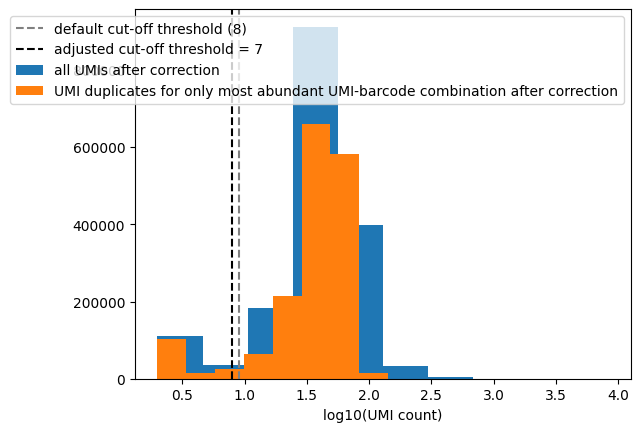

In [7]:
UMI_cutoff = parameters['UMI_cutoff']
UMI_cutoff_adjusted = 7
plt.hist(np.log10(all_seq_counts.astype(float)+1), label='all UMIs after correction')
plt.hist(np.log10((switching_tab['1st_abundant']).astype(float)+1), label='UMI duplicates for only most abundant UMI-barcode combination after correction') #these  are less likely to be UMI count errors from template switching
plt.axvline(np.log10(UMI_cutoff+1), label=f'default cut-off threshold ({UMI_cutoff})', color='grey', linestyle='dashed')
plt.axvline(np.log10(UMI_cutoff_adjusted+1), label=f'adjusted cut-off threshold = {UMI_cutoff_adjusted}', color='black', linestyle='dashed')
plt.xlabel('log10(UMI count)')
plt.legend()

Run below if you want to adjust the threshold in parameters yml

In [56]:
UMI_cutoff_adjusted = 8
with open(parameters_path/'parameters.yml', 'r') as file:
    data = yaml.load(file, Loader=yaml.FullLoader)
# Update the value in the dictionary
data['UMI_collapse_parameters']['UMI_cutoff'] = UMI_cutoff_adjusted
with open(parameters_path/'parameters.yml', 'w') as file:
    yaml.dump(data, file)

Now let's look at the distribution of putative template switching events versus expected number of UMI duplicates occuring by chance

In [15]:
# what frequency of duplicates would you expect in the library?
UMI_diversity = pow(4,14)
number_UMIs = len(switching_tab)
liklihood_two_molecules_the_same = (1/UMI_diversity)*number_UMIs
print(f"Number of duplicate UMIs expected by chance is {liklihood_two_molecules_the_same*100} %")

Number of duplicate UMIs expected by chance is 0.6246242672204971 %


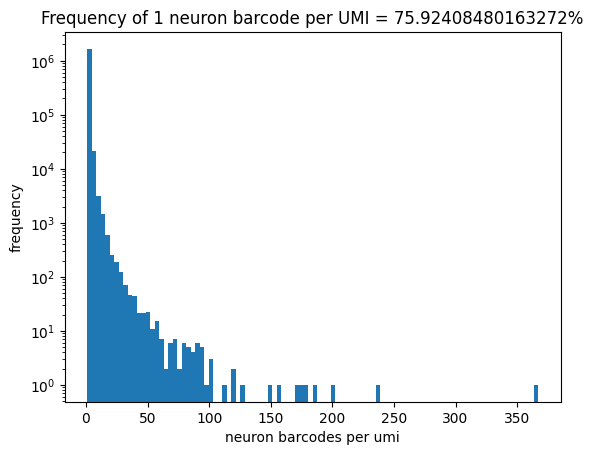

In [17]:
#plot frequency distribution of umi's associated with different neuron barcodes (i.e. template switching if # neuron barcodes associated with same umi >1)
plt.title(f"Frequency of 1 neuron barcode per UMI = {(len(switching_tab[switching_tab['different_neurons']==1]))/(len(switching_tab))*100}%", fontsize=12)
plt.yscale('log')
plt.xlabel('neuron barcodes per umi')
plt.ylabel('frequency')#plt.hist(np.log10(switching_tab['different_neurons'].astype(float)+1))
plt.hist(switching_tab['different_neurons'], bins = 100)
plt.yscale('log')

To distinguish between real template switching events (versus putative junk or re-used UMI's) let's look at the relative abundance of UMI counts of the same UMI associated with different neuron barcodes. Cut-off is determined by the different population distributions based on relative abundance of UMI counts. Template switching takes place during a PCR cycle. Therefore, one would expect the real UMI-barcode combination to be present at higher UMI counts than template switching events. UMI-barcode combinations found in similar abundance may not be template switching events. Therefore a minimum cut-off threshold is determined manually by inspecting distribution of populations associated with 1st/2nd most abundant UMIs. Below this threshold we will simply remove, since it's not expected to affect the overall distribution of barcodes and could be junk reads.

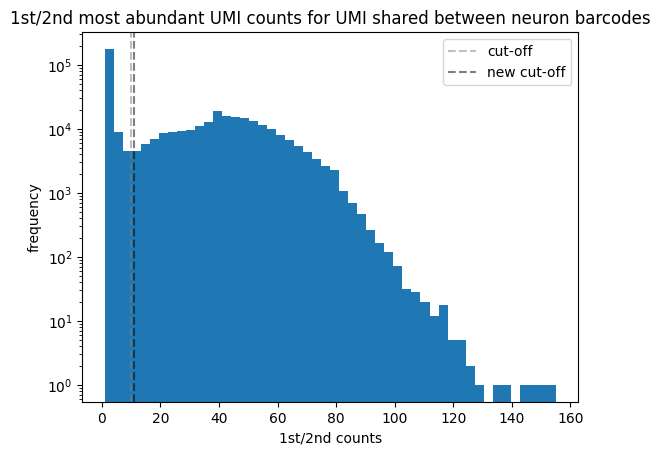

In [23]:
#within the umi's sharing a barcode, what is the distribution of 1st/second most abundant?
template_abundance_cutoff = parameters['template_switch_abundance']
altered_template_abundance_cutoff = 11
template_switches = switching_tab[switching_tab['different_neurons']>1]
plt.hist((template_switches['1st_abundant']/template_switches['2nd_abundant']), bins=50)
plt.title('1st/2nd most abundant UMI counts for UMI shared between neuron barcodes', fontsize=12)
plt.xlabel('1st/2nd counts')
plt.ylabel('frequency')
plt.yscale('log')
plt.axvline(x =template_abundance_cutoff, linestyle='dashed', color = "Grey", label = "cut-off", alpha=0.5)
plt.axvline(x =altered_template_abundance_cutoff, linestyle='dashed', color = "Black", label = "new cut-off", alpha=0.5)
plt.legend()


Since junk reads are associated with less complex sequences, lets check the cut-off by looking at features of the UMI's themselves associated with different 1st/2nd counts

In [29]:
#calculate shannon entropy for umi's to see if it might be bias for low complexity sequences
s = lambda i : - sum(f * log(f, 2) for f in ((j / len(i)) for j in Counter(i).values()))
template_switches['entropy'] = template_switches['UMI'].apply(s)
template_switches['relative_abundance'] = template_switches['1st_abundant']/template_switches['2nd_abundant']
#calculate AT content
AT_calc = lambda x: (x.count('A') + x.count('T')) / len(x)
template_switches['AT_content'] = template_switches['UMI'].apply(AT_calc)


/tmp/ipykernel_103323/226436895.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  template_switches['entropy'] = template_switches['UMI'].apply(s)
/tmp/ipykernel_103323/226436895.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  template_switches['relative_abundance'] = template_switches['1st_abundant']/template_switches['2nd_abundant']
/tmp/ipykernel_103323/226436895.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

Text(0.5, 1.0, 'Entropy of UMI sequence vs Abundance')

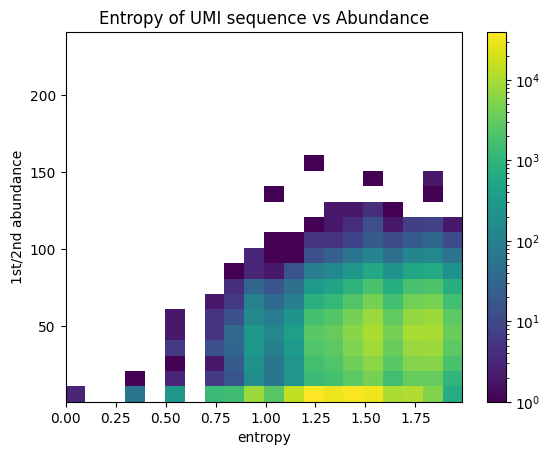

In [33]:
plt.hist2d(template_switches['entropy'], template_switches['relative_abundance'], norm=mpl.colors.LogNorm(), bins=(20, np.arange(1, 250, 10)))
plt.colorbar()
plt.xlabel('entropy')
plt.ylabel('1st/2nd abundance')
plt.title('Entropy of UMI sequence vs Abundance')

Text(0.5, 1.0, 'AT content of UMI sequence vs Abundance')

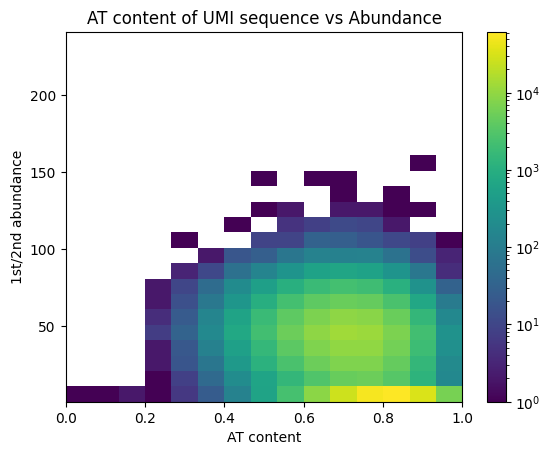

In [34]:
plt.hist2d(template_switches['AT_content'], template_switches['relative_abundance'], norm=mpl.colors.LogNorm(), bins=(15, np.arange(1, 250, 10)))
plt.colorbar()
plt.xlabel('AT content')
plt.ylabel('1st/2nd abundance')
plt.title('AT content of UMI sequence vs Abundance')

If change in template switch abundance threshold required, run cell below with altered parameters to update paramaters.yml file in processed data folder.

In [ ]:
template_abundance_cutoff_adjusted = 8
with open(parameters_path/'parameters.yml', 'r') as file:
    data = yaml.load(file, Loader=yaml.FullLoader)
# Update the value in the dictionary
data['UMI_collapse_parameters']['template_switch_abundance'] = template_abundance_cutoff_adjusted
with open(parameters_path/'parameters.yml', 'w') as file:
    yaml.dump(data, file)

Once paramaters for UMI cut-off and template switching abundance have been determined, run cell below to finish preprocessing

In [4]:
# start job for combining UMI and BC of corrected sequences
job_id = ps.combine_UMI_and_BC(use_slurm=True, slurm_folder=parameters["SLURM_DIR"], directory = str(parameters_path))
t = datetime.now()
print(f"Sent job for final pre-processing step at at {t}", flush=True)


Sent job for final pre-processing step at at 2023-10-26 16:34:30.837565
